본 프로젝트는 Singapore Maritime Dataset의 데이터를 N개 프레임마다 추출한 후 이를 **VOC format으로 만들고, 또 다시 이를 COCO data형식으로 제작하기 위해 jupyter notebook환경에서 작성된 코드**입니다.

데이터셋은 아래 주소를 통해 이용할 수 있습니다.

Dataset available here: https://sites.google.com/site/dilipprasad/home/singapore-maritime-dataset

**그리고 본 코드는 다음 주소의 내용을 토대로 작성되었습니다**.

**This code was written based on the contents of the following address**.

https://github.com/tilemmpon

**Citation**: 
D. K. Prasad, D. Rajan, L. Rachmawati, E. Rajabaly, and C. Quek, "Video Processing from Electro-optical Sensors for Object Detection and Tracking in Maritime Environment: A Survey," IEEE Transactions on Intelligent Transportation Systems (IEEE), 2017. 

In [ ]:
# 필요한 모듈을 불러오기기
from scipy.io import loadmat
from os import listdir
from os.path import isfile, join
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [ ]:
# 추출된 데이터들을 Google Drive에 저장하기 위해 drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the videos paths for both onboard and onshore data and generate dictionaries with it.

In [ ]:
# 각 SMD의 video dataset과 그 annotation file들의 경로를 지정
VIDEOS_PATH_ONSHORE = "/content/drive/MyDrive/VIS_Onboard/Videos"
OBJECT_ANNOTATIONS_ONSHORE_PATH = "/content/drive/MyDrive/VIS_Onshore/ObjectGT"
VIDEO_FRAMES_PATH_ONSHORE = '/content/drive/MyDrive/VIS_Onshore_frames/'

VIDEOS_PATH_ONBOARD = "/content/drive/MyDrive/VIS_Onboard/Videos"
OBJECT_ANNOTATIONS_ONBOARD_PATH = "/content/drive/MyDrive/VIS_Onboard/ObjectGT"
VIDEO_FRAMES_PATH_ONBOARD = '/content/drive/MyDrive/VIS_Onboard_frames/'

VIDEOS_PATH_NIR = "/content/drive/MyDrive/NIR/Videos"
OBJECT_ANNOTATIONS_NIR_PATH = "/content/drive/MyDrive/NIR/ObjectGT"
VIDEO_FRAMES_PATH_NIR = '/content/drive/MyDrive/NIR_frames/'

In [ ]:
# 모든 비디오 파일의 절대경로를 지정정
video_files_onshore = [join(VIDEOS_PATH_ONSHORE, f) for f in listdir(VIDEOS_PATH_ONSHORE) 
                       if isfile(join(VIDEOS_PATH_ONSHORE, f))]

video_files_onboard = [join(VIDEOS_PATH_ONBOARD, f) for f in listdir(VIDEOS_PATH_ONBOARD) 
                       if isfile(join(VIDEOS_PATH_ONBOARD, f))]

video_files_nir = [join(VIDEOS_PATH_NIR, f) for f in listdir(VIDEOS_PATH_NIR) 
                       if isfile(join(VIDEOS_PATH_NIR, f))]

**비디오 이름 : 비디오파일의 절대경로**

위와 같은 형식으로 dictionary를 구성한다

In [ ]:
video_files_onshore_dict = {}
for f in listdir(VIDEOS_PATH_ONSHORE):
    if isfile(join(VIDEOS_PATH_ONSHORE, f)):
        video_files_onshore_dict[f.split('.')[0]] = join(VIDEOS_PATH_ONSHORE, f)
        
video_files_onboard_dict = {}
for f in listdir(VIDEOS_PATH_ONBOARD):
    if isfile(join(VIDEOS_PATH_ONBOARD, f)):
        video_files_onboard_dict[f.split('.')[0]] = join(VIDEOS_PATH_ONBOARD, f)
        
video_files_nir_dict = {}
for f in listdir(VIDEOS_PATH_NIR):
    if isfile(join(VIDEOS_PATH_NIR, f)):
        video_files_nir_dict[f.split('.')[0]] = join(VIDEOS_PATH_NIR, f)

annotation file들의 정보를 관리하기 위해 다음 dictionary제작

In [ ]:
object_gt_files_onshore_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_ONSHORE_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_ONSHORE_PATH, f)):
        object_gt_files_onshore_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_ONSHORE_PATH, f)
        
object_gt_files_onboard_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_ONBOARD_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_ONBOARD_PATH, f)):
        object_gt_files_onboard_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_ONBOARD_PATH, f)
        
object_gt_files_nir_dict = {}
for f in listdir(OBJECT_ANNOTATIONS_NIR_PATH):
    if isfile(join(OBJECT_ANNOTATIONS_NIR_PATH, f)):
        object_gt_files_nir_dict[f.split('.')[0].replace('_ObjectGT','')] = join(OBJECT_ANNOTATIONS_NIR_PATH, f)

비디오파일과 annotation file의 개수가 다음과 같이 일치하지 않는다.

In [ ]:
print('Number of onshore videos: ', len(video_files_onshore_dict))
print('Number of onshore ground truth files: ', len(object_gt_files_onshore_dict))

print('Number of onboard videos: ', len(video_files_onboard_dict))
print('Number of onboard ground truth files: ', len(object_gt_files_onboard_dict))

print('Number of near infra-red videos: ', len(video_files_nir_dict))
print('Number of near infra-red ground truth files: ', len(object_gt_files_nir_dict))

Number of onshore videos:  11
Number of onshore ground truth files:  36
Number of onboard videos:  11
Number of onboard ground truth files:  4
Number of near infra-red videos:  30
Number of near infra-red ground truth files:  23


unlabeled video, 즉 annoatation file이 존재하지 않는 비디오파일도 있으며, 이는 나중에 모델이 최종 학습되고 난 이후 test과정에서 사용될 것이다

In [ ]:
# ground truth files are missing - find the corresponding videos
missing_files_onshore = []
for key in video_files_onshore_dict.keys():
    if key not in object_gt_files_onshore_dict:
        missing_files_onshore.append(key)
        
print("Unlabelled onshore videos: ", missing_files_onshore)

missing_files_onboard = []
for key in video_files_onboard_dict.keys():
    if key not in object_gt_files_onboard_dict:
        missing_files_onboard.append(key)
        
print("Unlabelled onbord videos: ", missing_files_onboard)

missing_files_nir = []
for key in video_files_nir_dict.keys():
    if key not in object_gt_files_nir_dict:
        missing_files_nir.append(key)
        
print("Unlabelled nir videos: ", missing_files_nir)


# set whether to remove or not the missing videos from the frames generation later
remove_missing_files = True
if remove_missing_files:
    for key in missing_files_onshore:
        del video_files_onshore_dict[key]
    for key in missing_files_onboard:
        del video_files_onboard_dict[key]
    for key in missing_files_nir:
        del video_files_nir_dict[key]
        
    print()
    print('Size of video dictionaries after removing the videos without ground truth:')
    print('Number of onshore videos: ', len(video_files_onshore_dict))
    print('Number of onshore ground truth files: ', len(object_gt_files_onshore_dict))

    print('Number of onboard videos: ', len(video_files_onboard_dict))
    print('Number of onboard ground truth files: ', len(object_gt_files_onboard_dict))

    print('Number of near infra-red videos: ', len(video_files_nir_dict))
    print('Number of near infra-red ground truth files: ', len(object_gt_files_nir_dict))

Unlabelled onshore videos:  ['MVI_0788_VIS_OB', 'MVI_0789_VIS_OB', 'MVI_0790_VIS_OB', 'MVI_0792_VIS_OB', 'MVI_0794_VIS_OB', 'MVI_0795_VIS_OB', 'MVI_0796_VIS_OB', 'MVI_0797_VIS_OB', 'MVI_0799_VIS_OB', 'MVI_0801_VIS_OB', 'MVI_0804_VIS_OB']
Unlabelled onbord videos:  ['MVI_0788_VIS_OB', 'MVI_0789_VIS_OB', 'MVI_0792_VIS_OB', 'MVI_0794_VIS_OB', 'MVI_0795_VIS_OB', 'MVI_0796_VIS_OB', 'MVI_0804_VIS_OB']
Unlabelled nir videos:  ['MVI_1474_NIR', 'MVI_1475_NIR', 'MVI_1478_NIR', 'MVI_1480_NIR', 'MVI_1481_NIR', 'MVI_1483_NIR', 'MVI_1484_NIR']

Size of video dictionaries after removing the videos without ground truth:
Number of onshore videos:  0
Number of onshore ground truth files:  36
Number of onboard videos:  4
Number of onboard ground truth files:  4
Number of near infra-red videos:  23
Number of near infra-red ground truth files:  23


### 비디오의 매 N번째 프레임을 추출하고 이를 train data와 test data로 나누는 과정이다. 여기서 N=35로 설정할 것이다. 더 촘촘한 간격으로 프레임을 추출할 수도 있으나, **데이터간의 연관성이 커지면 overfitting의 위험성이 존재**하기 때문에 그렇게 하지 않는다.

In [ ]:
# boolean to determine whether to have all frames in one or separate folders (onshore/onboard/nir)
SEPARATE_FOLDERS = False

In [ ]:
TRAIN_PATH = './train'
TEST_PATH = './test'
VIDEO_FRAMES_FOLDER_NAME_ONSHORE = 'VIS_Onshore'
VIDEO_FRAMES_FOLDER_NAME_ONBOARD = 'VIS_Onboard'
VIDEO_FRAMES_FOLDER_NAME_NIR = 'VIS_NIR'

if SEPARATE_FOLDERS:
    TRAIN_ONSHORE = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_ONSHORE)
    TEST_ONSHORE = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_ONSHORE)
    TRAIN_ONBOARD = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_ONBOARD)
    TEST_ONBOARD = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_ONBOARD)
    TRAIN_NIR = join(TRAIN_PATH, VIDEO_FRAMES_FOLDER_NAME_NIR)
    TEST_NIR = join(TEST_PATH, VIDEO_FRAMES_FOLDER_NAME_NIR)

    folder_names = [TRAIN_PATH, TEST_PATH, TRAIN_ONSHORE, TEST_ONSHORE, TRAIN_ONBOARD, TEST_ONBOARD, TRAIN_NIR, TEST_NIR]
else:
    folder_names = [TRAIN_PATH, TEST_PATH]

# first create the folders if they don't exist
for folder_name in folder_names:
    if not (os.path.isdir(folder_name)):
        os.mkdir(folder_name)

In [ ]:
def convert_videos_to_frames(video_dict, paths, frame_space=35, train_test_split=0.7):
    """
    Helper function to convert any video frames into jpg images and split them into training and test dataset.
    
    Parameters
    ----------
    
    video_dict : dictionary in the form <video_name>:<video_path>
    
    paths : tuple of the training and test paths to save the images. If both a set to the same path
            then all the generated frames will be place in this (same) directory.
            
    frame_space : the space between the generated frames. Default is 5.
    
    train_test_split : the ration to split the frames into train and test datasets. Default is 0.7
    """
    train_path = paths[0]
    test_path = paths[1]
    for video_key in video_dict:
        vidcap = cv2.VideoCapture(video_dict.get(video_key))
        
        # get total frames of video
        total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        success,image = vidcap.read()
        count = 0
        frame_count = 0
        success = True
        while success:
            if count % frame_space == 0:
                if (count <= train_test_split*total_frames):
                    cv2.imwrite(join(train_path, video_key) + "_frame%d.jpg" % count, image)     # save frame as JPEG file
                else:
                    cv2.imwrite(join(test_path, video_key) + "_frame%d.jpg" % count, image)
                frame_count += 1
            success,image = vidcap.read()
            #print('Read a new frame: ', success)
            count += 1
        print("Derived %d frames" % frame_count)

In [ ]:
# video로부터 every Nth Frame을 추출해온다
if SEPARATE_FOLDERS:
    convert_videos_to_frames(video_files_onboard_dict, [TRAIN_ONBOARD, TEST_ONBOARD])
    convert_videos_to_frames(video_files_onshore_dict, [TRAIN_ONSHORE, TEST_ONSHORE])
    convert_videos_to_frames(video_files_nir_dict, [TRAIN_NIR, TEST_NIR])
else:
    convert_videos_to_frames(video_files_onboard_dict, [TRAIN_PATH, TEST_PATH])
    convert_videos_to_frames(video_files_onshore_dict, [TRAIN_PATH, TEST_PATH])
    convert_videos_to_frames(video_files_nir_dict, [TRAIN_PATH, TEST_PATH])

Derived 18 frames
Derived 18 frames
Derived 18 frames
Derived 18 frames
Derived 13 frames
Derived 10 frames
Derived 10 frames
Derived 16 frames
Derived 18 frames
Derived 8 frames
Derived 18 frames
Derived 17 frames
Derived 17 frames
Derived 18 frames
Derived 18 frames
Derived 18 frames
Derived 14 frames
Derived 15 frames
Derived 9 frames
Derived 12 frames
Derived 18 frames
Derived 15 frames
Derived 9 frames
Derived 8 frames
Derived 16 frames
Derived 15 frames
Derived 23 frames


In [ ]:
# 추출한 Frame에 대한 VOC annotation file을 생성하기 위해 git clone
!git clone https://github.com/tilemmpon/Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics.git

Cloning into 'Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics'...
remote: Enumerating objects: 447, done.
remote: Total 447 (delta 0), reused 0 (delta 0), pack-reused 447
Receiving objects: 100% (447/447), 52.65 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [ ]:
# 현재 디렉토리를 변경한다
%cd /content/Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics

/content/Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics


In [ ]:
# dat으로 되어 있는 데이터 파일로부터 XML 형식의 annotation file로 만들기 위한 명령어이다.
# !python load_mat_into_csv_xml.py -i <path of unzipped SMD dataset> -o <folder to output/save csv and xml files> -f <path of the train/test folders that contain the frames>
!python load_mat_into_csv_xml.py -i /content/drive/MyDrive -o /content -f /content

Total objects in train dataset:  1869
Total objects in test dataset:  700
Successfully converted mat to csv.


XML파일대로 시각화를 진행해 보자

img shape: (1080, 1920, 3)


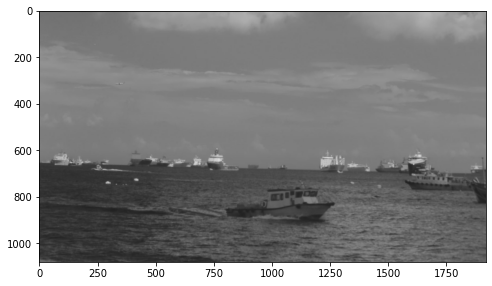

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

# 코랩 버전은 상대 경로를 사용하지 않습니다. /content 디렉토리를 기준으로 절대 경로를 이용
# default_dir 은 /content/data 로 지정하고 os.path.join()으로 상세 파일/디렉토리를 지정
default_dir = '/content'
img = cv2.imread(os.path.join(default_dir, 'train/MVI_1463_NIR_frame140.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [ ]:
# annotation file보기
!cat /content/train_annotations/MVI_1463_NIR_frame140.xml

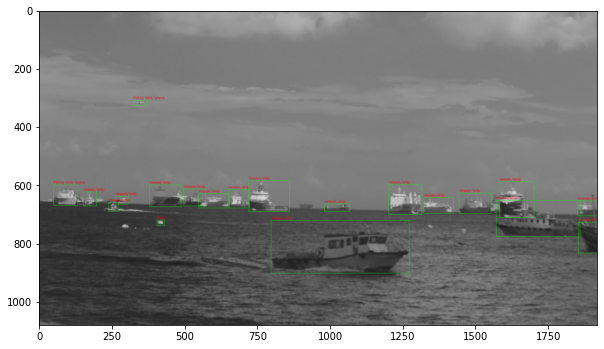

In [ ]:
import cv2
import os
import xml.etree.ElementTree as ET

xml_file = "/content/train_annotations/MVI_1463_NIR_frame140.xml"

tree = ET.parse(xml_file)
root = tree.getroot()

image_name = root.find('filename').text
full_image_name = '/content/train/MVI_1463_NIR_frame140.jpg'

img = cv2.imread(full_image_name)
# opencv의 rectangle()는 인자로 들어온 이미지 배열에 그대로 사각형을 그려주므로 별도의 이미지 배열에 그림 작업 수행. 
draw_img = img.copy()
# OpenCV는 RGB가 아니라 BGR이므로 빨간색은 (0, 0, 255)
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 파일내에 있는 모든 object Element를 찾음.
objects_list = []
for obj in root.findall('object'):
    xmlbox = obj.find('bndbox')
    
    left = round(float(xmlbox.find('xmin').text))
    top = round(float(xmlbox.find('ymin').text))
    right = round(float(xmlbox.find('xmax').text))
    bottom = round(float(xmlbox.find('ymax').text))
    
    class_name=obj.find('name').text
    
    # draw_img 배열의 좌상단 우하단 좌표에 녹색으로 box 표시 
    cv2.rectangle(draw_img, (left, top), (right, bottom), color=green_color, thickness=1)
    # draw_img 배열의 좌상단 좌표에 빨간색으로 클래스명 표시
    cv2.putText(draw_img, class_name, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, thickness=1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)

여기까지 하면 모든 데이터셋과 annotation File생성이 끝난다

그런데 이용하기 전에 할 일이 있다. **mmDetection에서는 VOC data를 사용하려면, 이걸 먼저 MS-COCO dataset의 형태로 parsing을 한 이후에 사용**하여야 하는데, 그 작업을 할 것이다.

In [ ]:
# VOC data를 COCO로 변환하는 package를 사용해서 변경하도록 하자
!git clone https://github.com/yukkyo/voc2coco.git

Cloning into 'voc2coco'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 436 (delta 11), reused 19 (delta 6), pack-reused 409
Receiving objects: 100% (436/436), 216.32 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (387/387), done.


In [ ]:
import os

# 먼저, labels.txt라는 파일을 생성해서 그 내용은 다음과 같이 모든 classes의 이름이 line by line으로 들어가야 한다
with open('/content/labels.txt', "w") as f:
    f.write("Ferry\n")
    f.write("Buoy\n")
    f.write("Vessel/ship\n")
    f.write("Speed boat\n")
    f.write("Boat\n")
    f.write("Kayak\n")
    f.write("Sail boat\n")
    f.write("Swimming person\n")
    f.write("Flying bird/plane\n")
    f.write("Other")

!cat /content/labels.txt

Ferry
Buoy
Vessel/ship
Speed boat
Boat
Kayak
Sail boat
Swimming person
Flying bird/plane
Other

### PASCAL VOC를 COCO 형식으로 변환하려면 어떤 파일이 학습용인지, 어떤 파일이 검증용인지 분류를 해놓은 **txt파일이 필요한데, 그것이 없어서 직접 만들어주고 있는 과정**이다.

In [ ]:
train_annotation_path = "/content/train_annotations"
test_annotation_path = "/content/test_annotations"
train_file_list = os.listdir(train_annotation_path)
test_file_list = os.listdir(test_annotation_path)

# 확장자를 빼고 파일명만 가져오기
for i in range(len(train_file_list)):
    file = train_file_list[i]
    idx = file.index(".")
    train_file_list[i] = file[:idx]

for i in range(len(test_file_list)):
    file = test_file_list[i]
    idx = file.index(".")
    test_file_list[i] = file[:idx]


# 파일명을 이용해 annotation list file을 만들자
with open("/content/train.txt", 'w+') as lf:
        lf.write('\n'.join(train_file_list))

with open("/content/val.txt", 'w+') as lf:
        lf.write('\n'.join(test_file_list))    

In [ ]:
%cd /content/Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics

/content/Singapore-Maritime-Dataset-Frames-Ground-Truth-Generation-and-Statistics


### 아래 cell을 수행하기 전에 voc2coco.py에서 label2id함수의 split()을 split("\n")으로 바꾸어야 한다. 소스코드를 확인해보니 클래스의 이름을 공백을 기준으로 line split을 진행 하는데, 본 프로젝트에서는 클래스명에 공백이 들어가기 때문에 오류가 발생한다.

In [ ]:
# 아래 cell을 수해하기 전에 voc2coco.py에서 label2id함수의 split()을 split("\n")으로 바꾸어야 한다

# VOC형태의 BCCD Dataset을 COCO로 변환할 것이다. 
# 그래서 최종적으로 학습/검증/테스트 용 json annotation을 생성하는 다음 script를 시행한다


%cd voc2coco

# Train Dataset (COCO-type) 만드는 과정
# --ann_cir : Annotations파일이 있는 경로
# --ann_ids : 어떤것이 train/val/test로 사용될 데이터인지 그 정보가 들어있는 text파일
# --labels : 위에서 제작한 모든 클래스명이 나열된 text파일
# --output : 변환 완료된 COCO-type Dataset json파일이 저장될 경로

!python voc2coco.py --ann_dir /content/train_annotations \
--ann_ids /content/train.txt \
--labels /content/labels.txt \
--output /content/drive/MyDrive/SMDDataset/35_Frame/train.json \
--ext xml


# Test Dataset (COCO-type) 만드는 과정
!python voc2coco.py --ann_dir /content/test_annotations \
--ann_ids /content/val.txt \
--labels /content/labels.txt \
--output /content/drive/MyDrive/SMDDataset/35_Frame/val.json \
--ext xml